In [66]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

from torchvision import models
from visualization.modules import *
from visualization.data import *
from visualization.image_proc import *
from visualization.interpret import NetLens

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
np.random.seed(0)
torch.manual_seed(0)

In [118]:
#original_model = models.alexnet(pretrained=True)
#model = LayeredModule.from_alexnet(original_model)

original_model = models.vgg19(pretrained=True)
model = LayeredModule.from_nested_cnn(original_model)

In [119]:
original_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [120]:
print('\n'.join(model.layers.keys()))

features-conv-0
features-relu-0
features-conv-1
features-relu-1
features-pool-0
features-conv-2
features-relu-2
features-conv-3
features-relu-3
features-pool-1
features-conv-4
features-relu-4
features-conv-5
features-relu-5
features-conv-6
features-relu-6
features-conv-7
features-relu-7
features-pool-2
features-conv-8
features-relu-8
features-conv-9
features-relu-9
features-conv-10
features-relu-10
features-conv-11
features-relu-11
features-pool-3
features-conv-12
features-relu-12
features-conv-13
features-relu-13
features-conv-14
features-relu-14
features-conv-15
features-relu-15
features-pool-4
avgpool-0
flatten
classifier-linear-0
classifier-relu-0
classifier-dropout-0
classifier-linear-1
classifier-relu-1
classifier-dropout-1
classifier-linear-2


In [121]:
model

LayeredModule(
  (layers): ModuleDict(
    (features-conv-0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (features-relu-0): ReLU()
    (features-conv-1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (features-relu-1): ReLU()
    (features-pool-0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (features-conv-2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (features-relu-2): ReLU()
    (features-conv-3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (features-relu-3): ReLU()
    (features-pool-1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (features-conv-4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (features-relu-4): ReLU()
    (features-conv-5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (features-relu-5): ReLU()
    (features-conv-6): Conv2d(256, 256, kerne

In [122]:
len(model.layers)

46

In [123]:
original_img, name, target_class = get_example_data(0, img_path='../old_visual/input_images/')

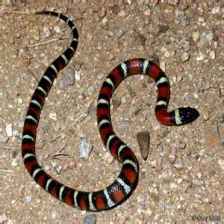

In [124]:
original_img

In [125]:
prep_img = preprocess_image(original_img)

In [126]:
tuple(prep_img.shape[2:])

(224, 224)

In [127]:
prep_img.requires_grad

True

In [128]:
output = original_model(prep_img)
output.shape, torch.argmax(output)

(torch.Size([1, 1000]), tensor(56))

In [129]:
output2 = model(prep_img)
output2.shape, torch.argmax(output2)

(torch.Size([1, 1000]), tensor(56))

In [130]:
torch.all(output == output2)

tensor(False)

In [131]:
torch.max(output)

tensor(24.8127, grad_fn=<MaxBackward1>)

In [132]:
torch.max(torch.abs(output - output2))

tensor(7.0654, grad_fn=<MaxBackward1>)

### Vanilla Backprop

In [133]:
nl = NetLens(model, prep_img, target_class)

In [134]:
gradient = nl.get_input_gradient()

In [135]:
gradient.shape

torch.Size([1, 3, 224, 224])

In [136]:
vanilla_grads = gradient.numpy()[0]

In [137]:
vanilla_grads.shape

(3, 224, 224)

In [138]:
vanilla_grads_color = normalize_to_range(vanilla_grads)

In [139]:
vanilla_grads_color.shape

(3, 224, 224)

In [140]:
vanilla_grads_gray = convert_to_grayscale(vanilla_grads)
vanilla_grads_gray.shape

(224, 224)

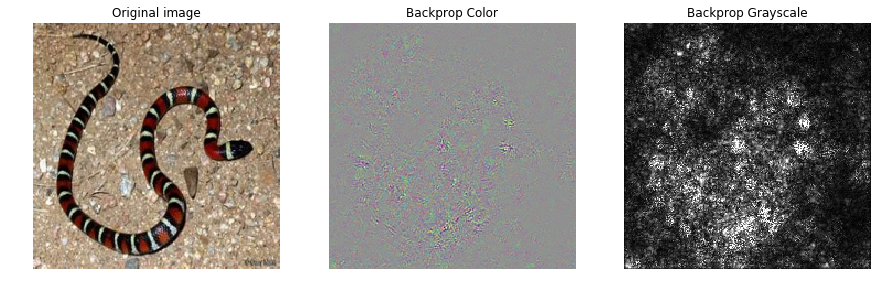

In [141]:
show_images([original_img, vanilla_grads_color, vanilla_grads_gray], ['Original image', 'Backprop Color', 'Backprop Grayscale']);

### Guided Backprop

In [142]:
gradient = nl.get_input_gradient(guided=True)

In [143]:
gradient.shape

torch.Size([1, 3, 224, 224])

In [144]:
nl.model.hooked_layer_keys

{'classifier-relu-0',
 'classifier-relu-1',
 'features-relu-0',
 'features-relu-1',
 'features-relu-10',
 'features-relu-11',
 'features-relu-12',
 'features-relu-13',
 'features-relu-14',
 'features-relu-15',
 'features-relu-2',
 'features-relu-3',
 'features-relu-4',
 'features-relu-5',
 'features-relu-6',
 'features-relu-7',
 'features-relu-8',
 'features-relu-9',
 'relu-0'}

In [145]:
nl.model.layers.keys()

odict_keys(['features-conv-0', 'features-relu-0', 'features-conv-1', 'features-relu-1', 'features-pool-0', 'features-conv-2', 'features-relu-2', 'features-conv-3', 'features-relu-3', 'features-pool-1', 'features-conv-4', 'features-relu-4', 'features-conv-5', 'features-relu-5', 'features-conv-6', 'features-relu-6', 'features-conv-7', 'features-relu-7', 'features-pool-2', 'features-conv-8', 'features-relu-8', 'features-conv-9', 'features-relu-9', 'features-conv-10', 'features-relu-10', 'features-conv-11', 'features-relu-11', 'features-pool-3', 'features-conv-12', 'features-relu-12', 'features-conv-13', 'features-relu-13', 'features-conv-14', 'features-relu-14', 'features-conv-15', 'features-relu-15', 'features-pool-4', 'avgpool-0', 'flatten', 'classifier-linear-0', 'classifier-relu-0', 'classifier-dropout-0', 'classifier-linear-1', 'classifier-relu-1', 'classifier-dropout-1', 'classifier-linear-2'])

In [146]:
vanilla_grads = gradient.numpy()[0]

In [147]:
vanilla_grads.shape

(3, 224, 224)

In [148]:
vanilla_grads_color = normalize_to_range(vanilla_grads)

In [149]:
vanilla_grads_color.shape

(3, 224, 224)

In [150]:
vanilla_grads_gray = convert_to_grayscale(vanilla_grads)
vanilla_grads_gray.shape

(224, 224)

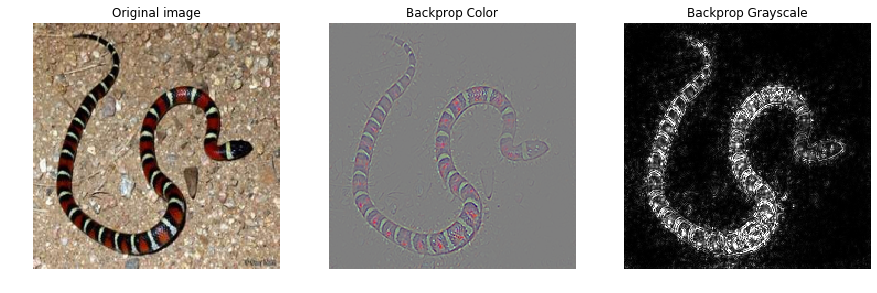

In [151]:
show_images([original_img, vanilla_grads_color, vanilla_grads_gray], ['Original image', 'Backprop Color', 'Backprop Grayscale']);

### For all images

In [156]:
def get_backprop(example_index, guided):
    original_img, name, target_class = get_example_data(example_index, img_path='../old_visual/input_images/')
    pretrained_model = models.vgg19(pretrained=True)
    # Vanilla backprop
    model = LayeredModule.from_nested_cnn(pretrained_model)
    # Generate and show gradients
    prep_img = preprocess_image(original_img)
    NetLens(model, prep_img, target_class).show_gradient_backprop(guided)

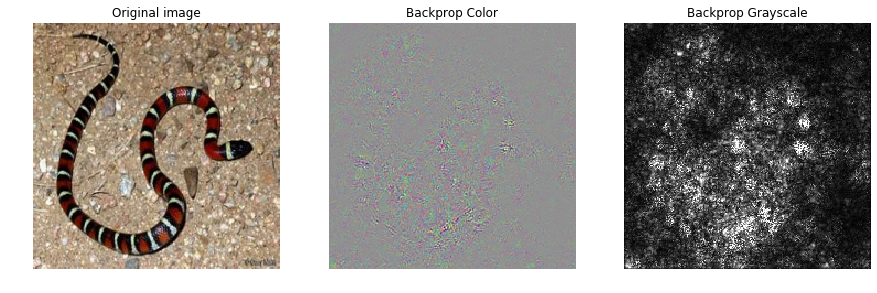

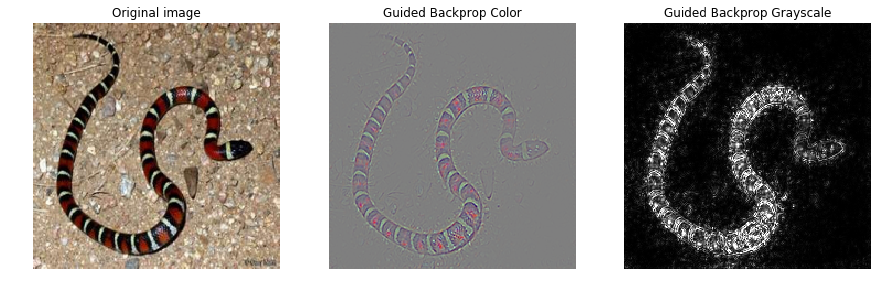

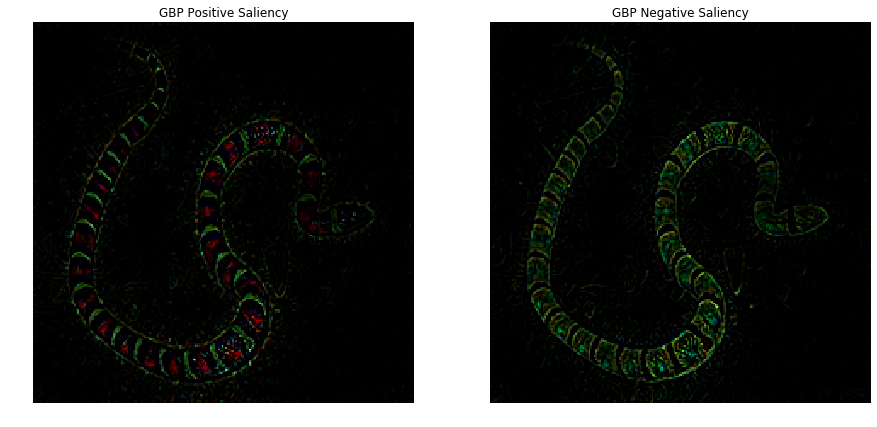

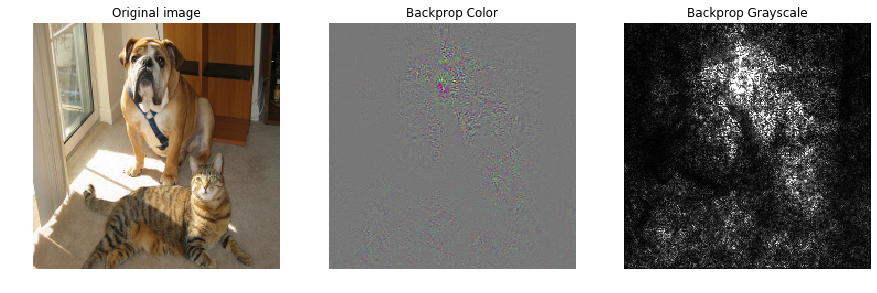

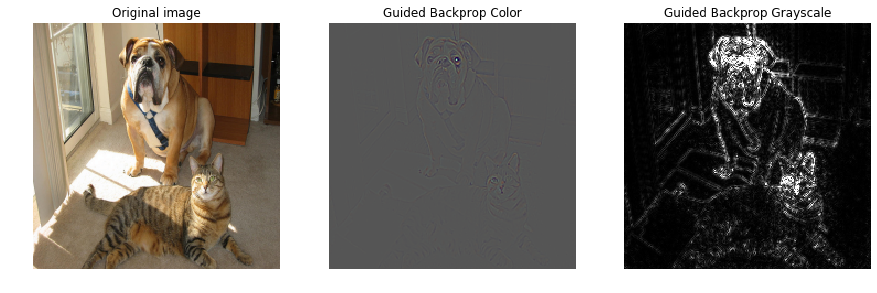

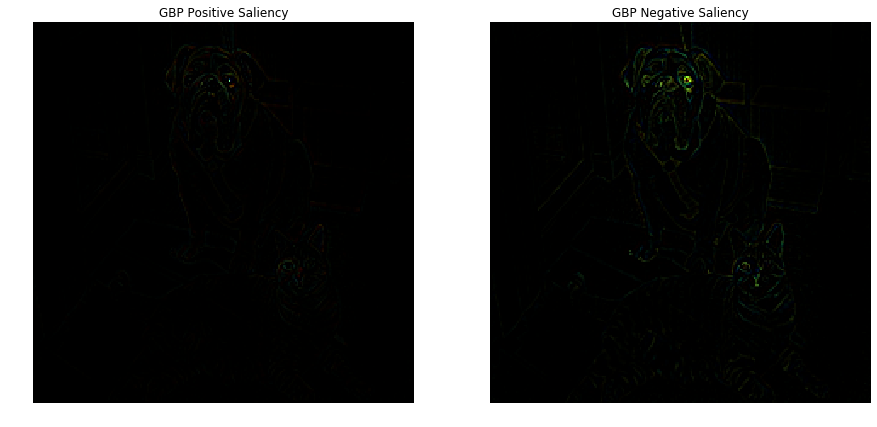

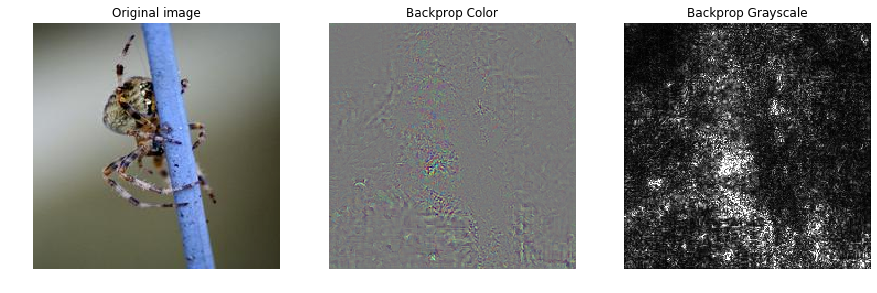

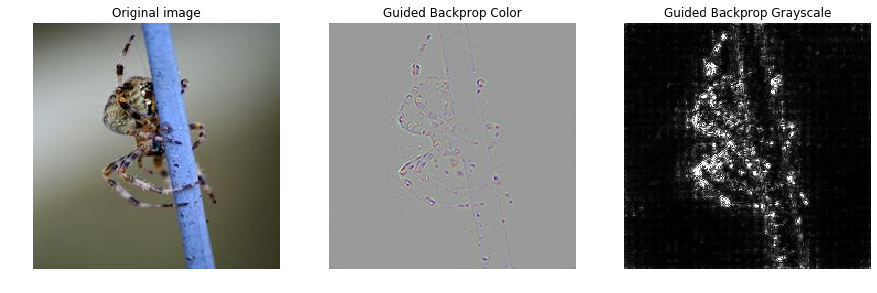

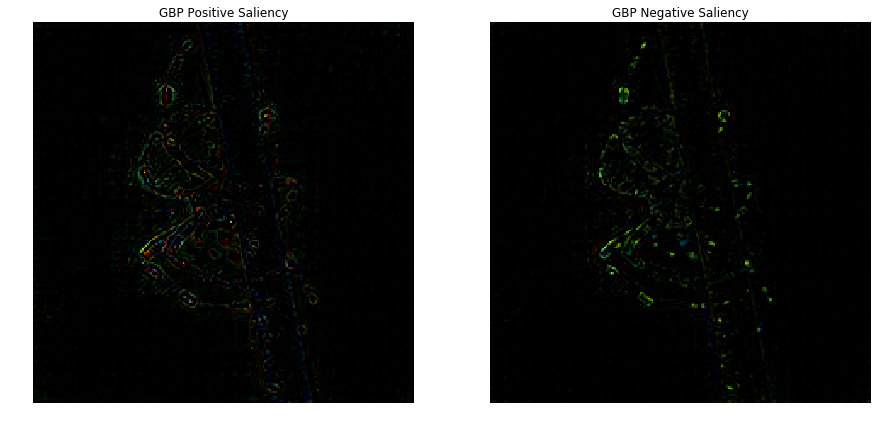

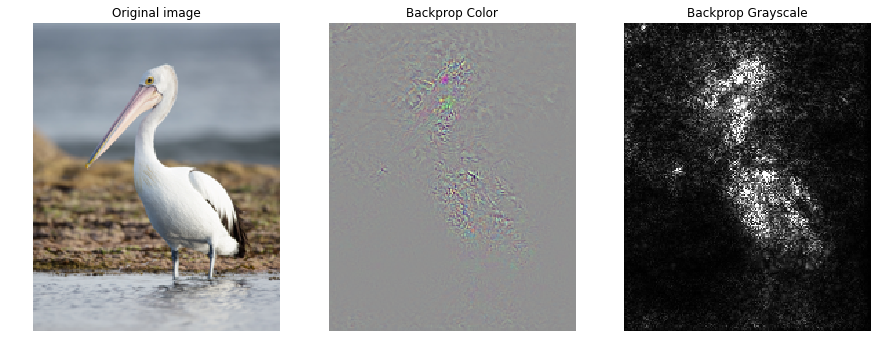

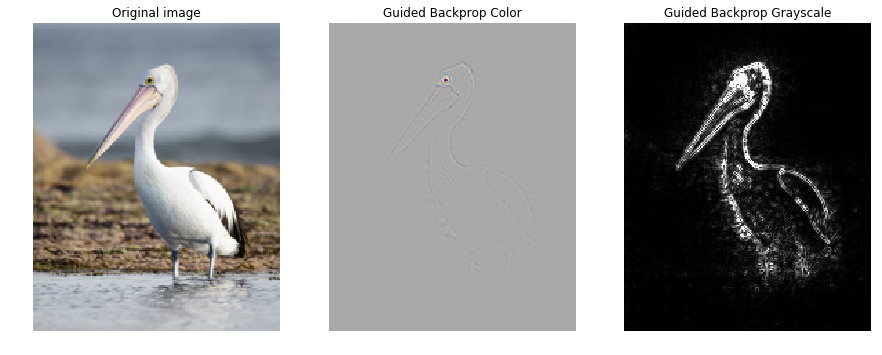

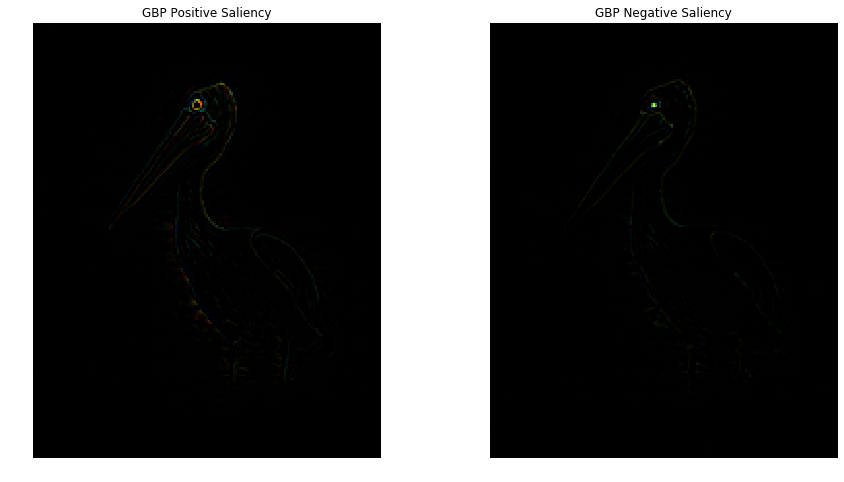

In [157]:
for idx in range(4):
    for guided in (False, True):
        get_backprop(idx, guided)

### Smooth Backprop

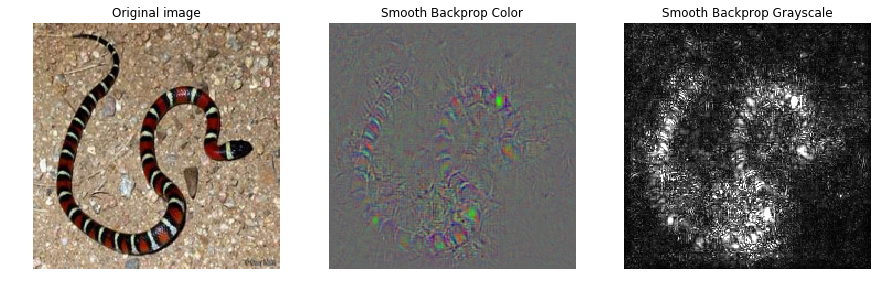

In [28]:
nl.show_smooth_gradient(guided=False, param_sigma_multiplier=4.0)

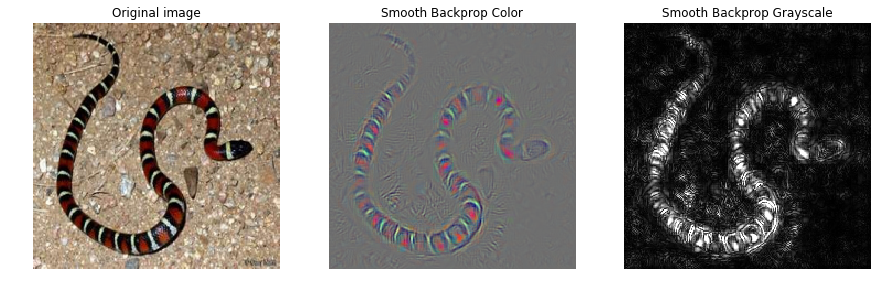

In [29]:
nl.show_smooth_gradient(guided=True, param_sigma_multiplier=1.0)

### Integrated Gradients

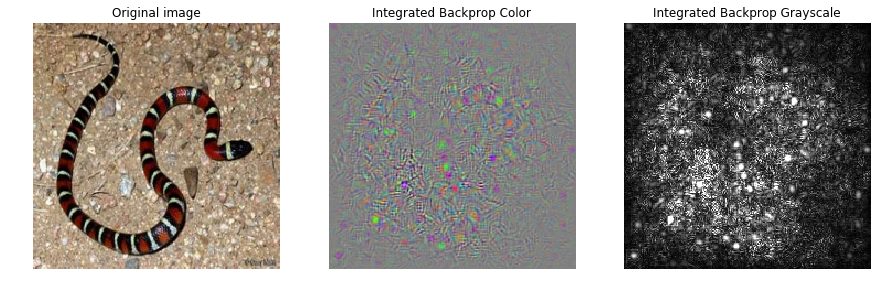

In [10]:
nl.show_integrated_gradient(guided=False)

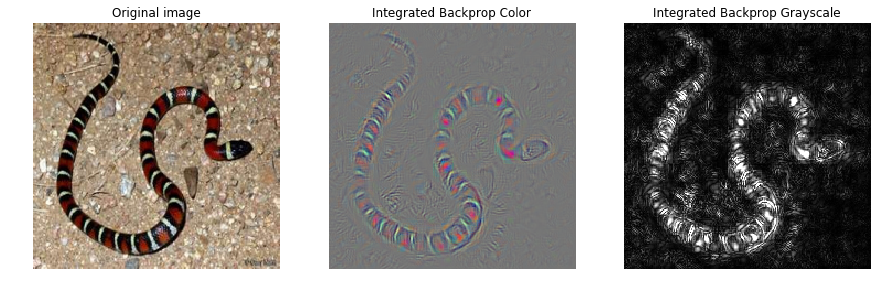

In [11]:
nl.show_integrated_gradient(guided=True)

### Layer activation gradient

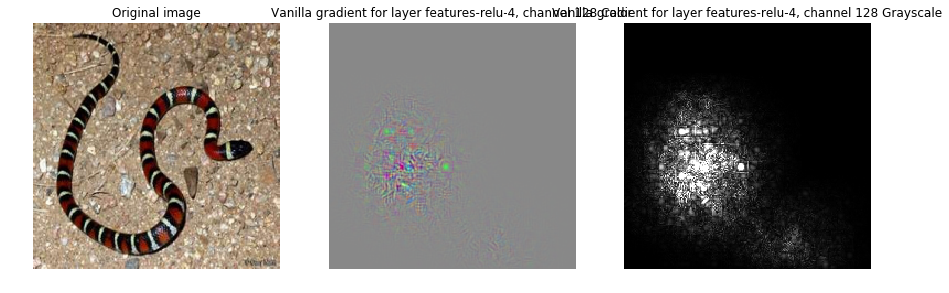

In [18]:
nl.show_input_gradient_for_layer_activation('features-relu-4', 128, guided=False)

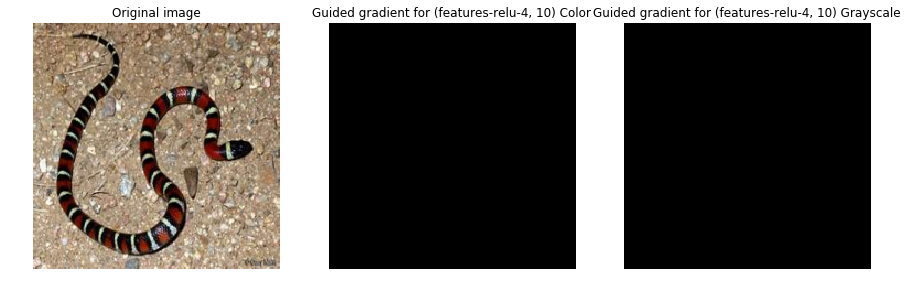

In [20]:
nl.show_input_gradient_for_layer_activation('features-relu-4', 10, guided=True)

In [36]:
conv_output = nl.model.hooks_layers.get_stored('features-relu-4')
conv_output.shape, conv_output.requires_grad

(torch.Size([1, 256, 13, 13]), False)

In [9]:
co = nl.model.forward(nl.input_image, until_layer='features-relu-4')

In [11]:
co.shape, co.requires_grad

(torch.Size([1, 256, 13, 13]), True)